In [ ]:
INPUT Shape= 224*224 

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


In [3]:
train_df = pd.read_csv('/kaggle/input/urpc-tf/train/_annotations.csv')
test_df = pd.read_csv('/kaggle/input/urpc-tf/test/_annotations.csv')
valid_df = pd.read_csv('/kaggle/input/urpc-tf/valid/_annotations.csv')

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/kaggle/input/urpc-tf/train',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 28427 validated image filenames belonging to 4 classes.


In [6]:
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/kaggle/input/urpc-tf/valid',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 5676 validated image filenames belonging to 4 classes.


In [7]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/kaggle/input/urpc-tf/test',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 1994 validated image filenames belonging to 4 classes.


In [8]:
# Loading vgg16 model Also Fine-Tuning the Fully-connected Layer

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(460, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation='relu')(x)
x = Dense(188, activation='relu')(x)
 
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
custom_learning_rate = 0.0003102
optimizer = Adam(learning_rate=custom_learning_rate)

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    11,540,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           75

 Total params: 26,292,916 (100.30 MB)

 Trainable params: 11,578,228 (44.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# Training Of Model

history_vgg16= model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n // valid_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718741121.807018     608 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718741121.831113     608 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/444 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.5655 - loss: 1.7688

W0000 00:00:1718741257.757205     607 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.5721 - loss: 1.6730

W0000 00:00:1718741281.745979     607 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 251s 418ms/step - accuracy: 0.5722 - loss: 1.6718 - val_accuracy: 0.6357 - val_loss: 0.9108
Epoch 2/20
  1/444 ━━━━━━━━━━━━━━━━━━━━ 1:53 255ms/step - accuracy: 0.6406 - loss: 0.8958

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


444/444 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - accuracy: 0.6406 - loss: 0.8958 - val_accuracy: 0.5682 - val_loss: 1.0018
Epoch 3/20


W0000 00:00:1718741348.843243     606 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


444/444 ━━━━━━━━━━━━━━━━━━━━ 152s 337ms/step - accuracy: 0.6306 - loss: 0.9132 - val_accuracy: 0.6326 - val_loss: 0.8983
Epoch 4/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5938 - loss: 0.8829 - val_accuracy: 0.6818 - val_loss: 0.8977
Epoch 5/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 150s 334ms/step - accuracy: 0.6207 - loss: 0.8763 - val_accuracy: 0.6341 - val_loss: 0.9105
Epoch 6/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5781 - loss: 0.9640 - val_accuracy: 0.6136 - val_loss: 0.8255
Epoch 7/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 147s 327ms/step - accuracy: 0.6305 - loss: 0.8498 - val_accuracy: 0.6223 - val_loss: 0.9053
Epoch 8/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6562 - loss: 0.7889 - val_accuracy: 0.6818 - val_loss: 0.7273
Epoch 9/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/step - accuracy: 0.6252 - loss: 0.8351 - val_accuracy: 0.6321 - val_loss: 0.8907
Epoch 10/20
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6250 - loss: 1.0148 - va

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 271ms/step - accuracy: 0.6416 - loss: 0.8296
Test loss: 0.8346469402313232
Test accuracy: 0.6436492204666138


In [13]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    

    plt.show()

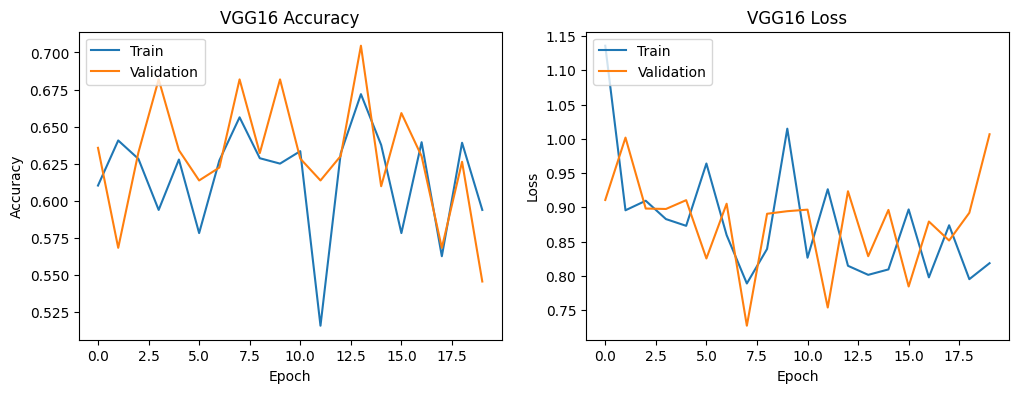

In [14]:
# Plot history for VGG16
plot_history(history_vgg16,'VGG16')

In [16]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step
              precision    recall  f1-score   support

     echinus       0.43      0.54      0.48       835
 holothurian       0.15      0.14      0.15       275
     scallop       0.28      0.30      0.29       635
    starfish       0.00      0.00      0.00       249

    accuracy                           0.34      1994
   macro avg       0.21      0.24      0.23      1994
weighted avg       0.29      0.34      0.31      1994



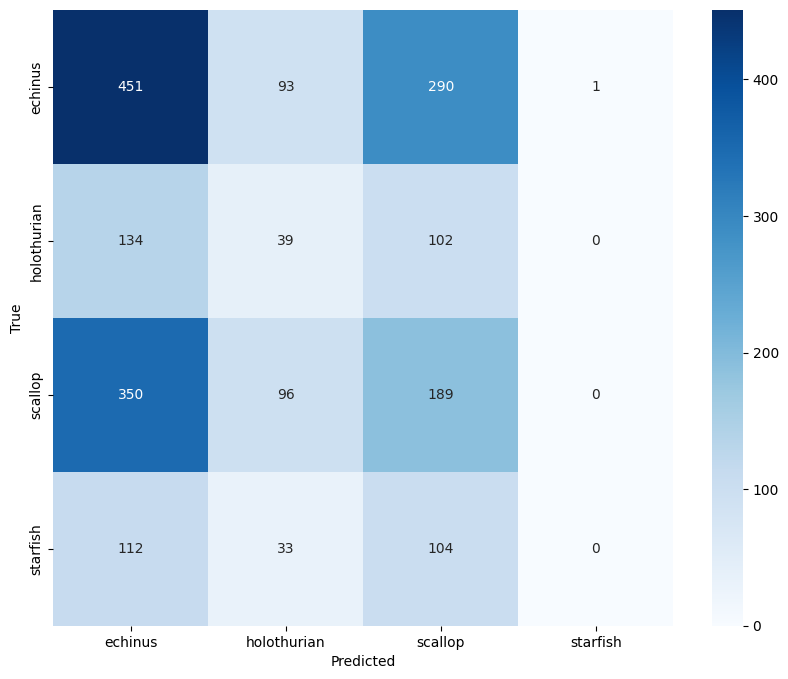

In [17]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.28885475014514833
Recall: 0.34052156469408223
F1 Score: 0.3119639745083788


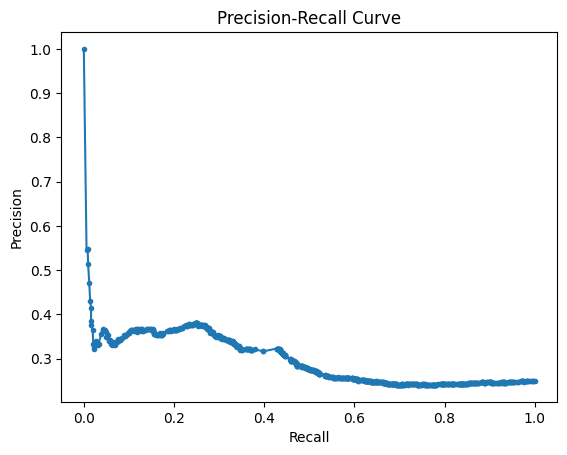

In [19]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [20]:
# Save the VGG16 model
model.save('Vgg16_URPC19(64.36%).h5')